In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%cd /Midgard/home/amirme/an_explanation_model
from source.project_manager import (
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from source.data_manager import plot_masks,fisher_information,preprocess_masks,symmetric_minmax_normalize,minmax_normalize,sum_channels
from source.labels import IMAGENET_LABELS

/Midgard/home/amirme/an_explanation_model


In [37]:
project_metadata = load_experiment_metadata(glob_path="experiment_3/*")
print(project_metadata.columns)
project_metadata["projection_distribution"].fillna("None", inplace=True)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "alpha_mask_value",
        "projection_distribution",
        "projection_top_k",
    ]
).sort_index()
print(project_metadata.shape)

Index(['method', 'alpha_mask_type', 'alpha_mask_value', 'projection_type',
       'projection_top_k', 'baseline_mask_type', 'write_demo', 'architecture',
       'max_batches', 'min_change', 'seed', 'batch_size', 'num_classes',
       'input_shape', 'image_index', 'monitored_statistic', 'monitored_stream',
       'dataset', 'output_layer', 'stats_log_level', 'label', 'image_path',
       'time_to_compute', 'batch_index', 'monitored_statistic_change',
       'data_path', 'stream_name', 'stream_statistic', 'csv_file_path',
       'projection_distribution'],
      dtype='object')
(264, 24)


In [38]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))

stream_name            stream_statistic  image_index  alpha_mask_value  projection_distribution  projection_top_k
log_probs              meanx             3            0.2               None                     1                   1
vanilla_grad_mask      meanx2            3            0.2               None                     6                   1
results_at_projection  meanx             11           0.3               None                     3                   1
                                                                                                 4                   1
                                                                                                 5                   1
                                                                                                                    ..
                                         3            0.2               None                     6                   1
                                                     

In [47]:
for name in project_metadata.index.names:
    print(name,"=",project_metadata.index.get_level_values(name).value_counts().to_dict())

stream_name = {'log_probs': 88, 'results_at_projection': 88, 'vanilla_grad_mask': 88}
stream_statistic = {'meanx': 176, 'meanx2': 88}
image_index = {3: 66, 5: 66, 9: 66, 11: 66}
alpha_mask_value = {0.2: 132, 0.3: 132}
projection_distribution = {'None': 240, 'uniform': 24}
projection_top_k = {10: 48, 1: 24, 2: 24, 3: 24, 4: 24, 5: 24, 6: 24, 7: 24, 8: 24, 9: 24}


In [27]:
shape = (10, 1, 1, 1)
uniform_prior = np.ones(shape=shape) / shape[0]
temp_metadata = project_metadata.loc[("vanilla_grad_mask")]
fisher_masks = temp_metadata.groupby(["image_index", "alpha_mask_value"]).apply(
    fisher_information, prior=uniform_prior
)
titles = fisher_masks.index.to_series().apply(
    lambda x: f"{fisher_masks.index.names[0]} {x[0]} alpha {x[1]:.2f}"
)
fisher_masks = preprocess_masks(fisher_masks, preprocesses=[sum_channels, minmax_normalize])

TypeError: fisher_information() missing 1 required positional argument: 'static_meanx2'

In [5]:
imshow_args = {"cmap": "viridis"}

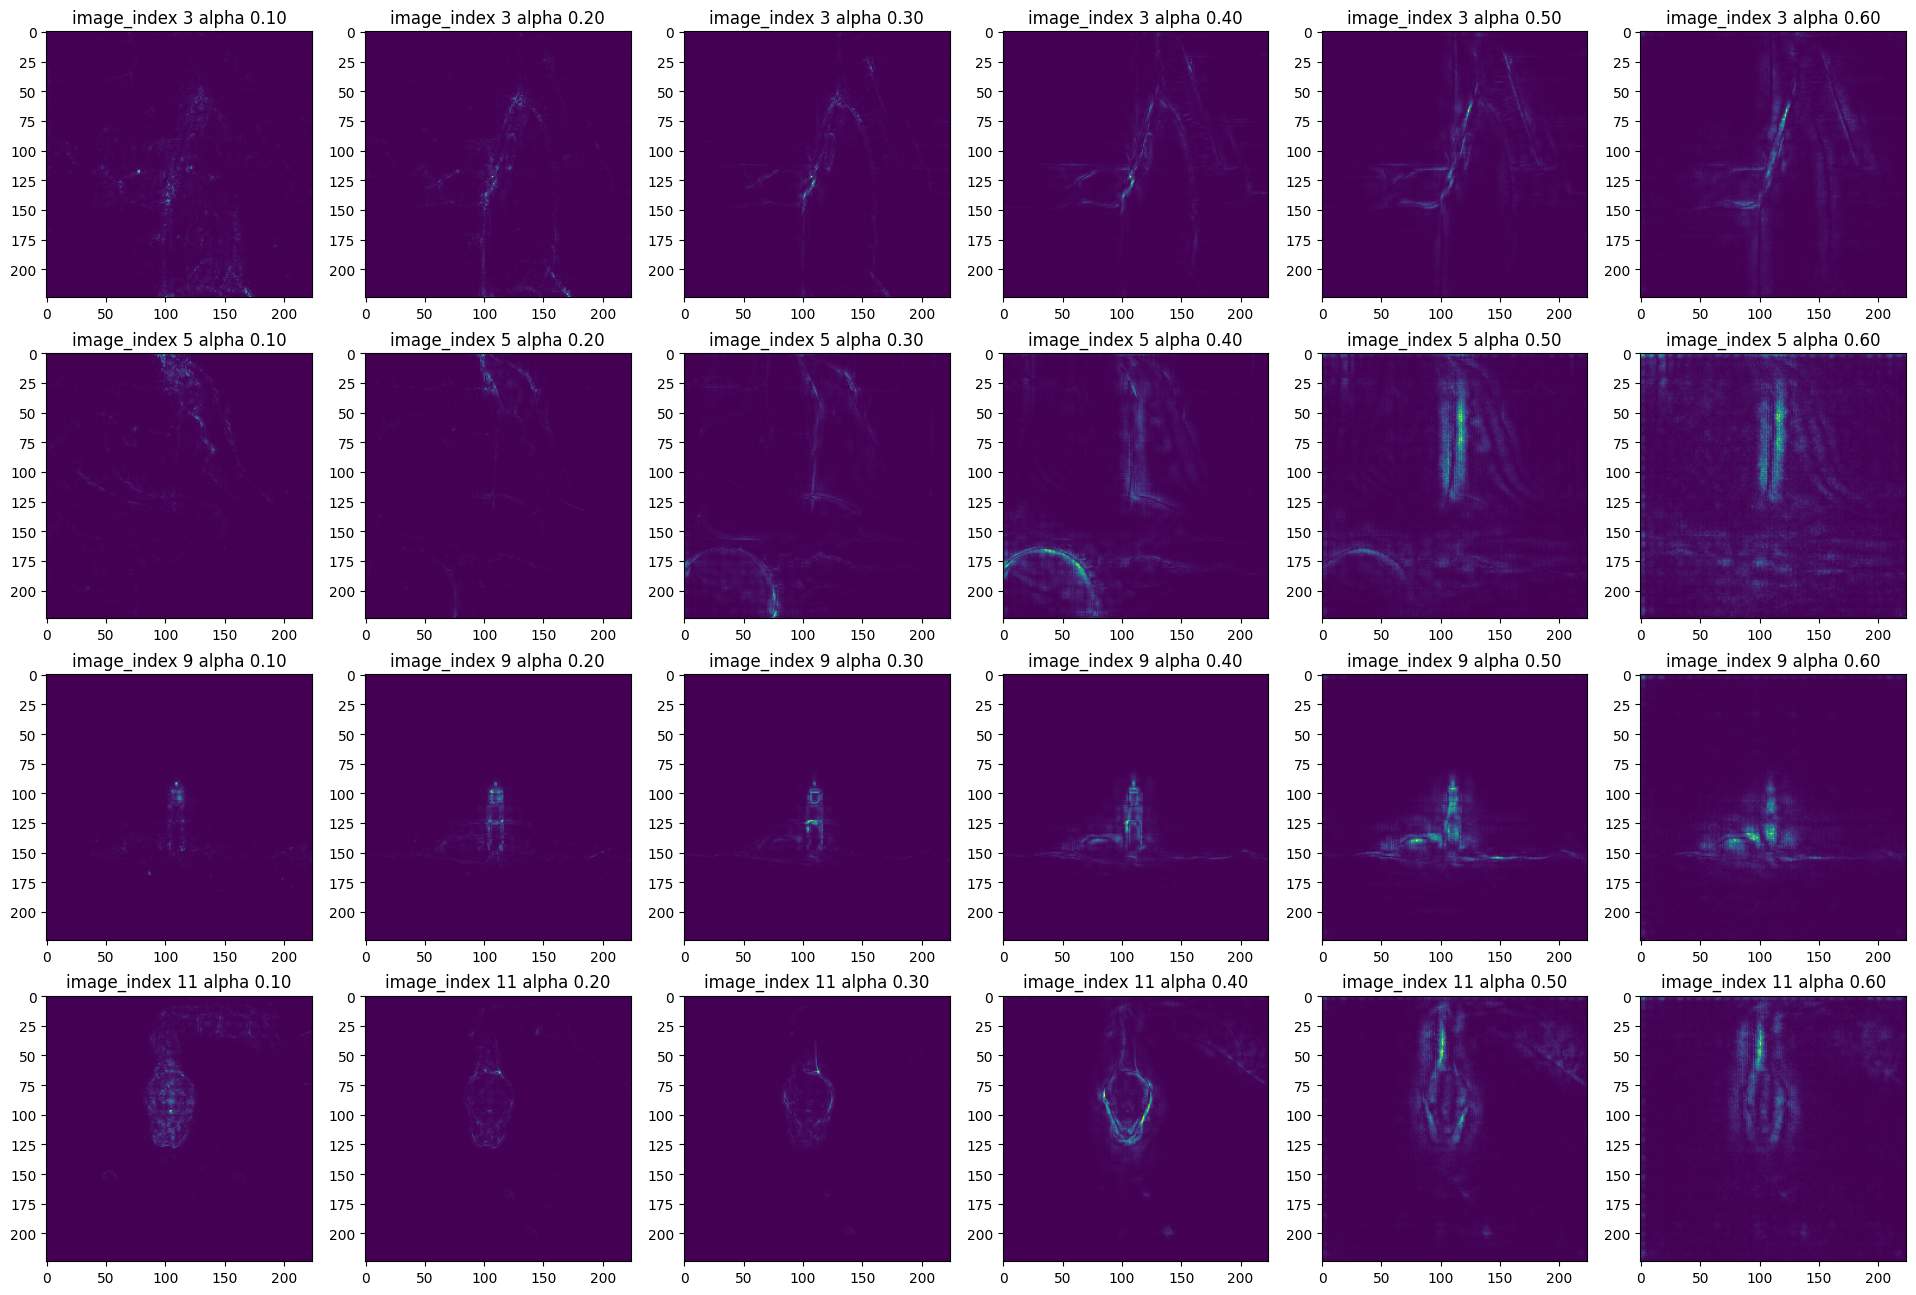

In [36]:
plot_masks(
    fisher_masks, titles=titles, imshow_args=imshow_args, ncols=6
)

['alpha_mask_value', 'projection_top_k']


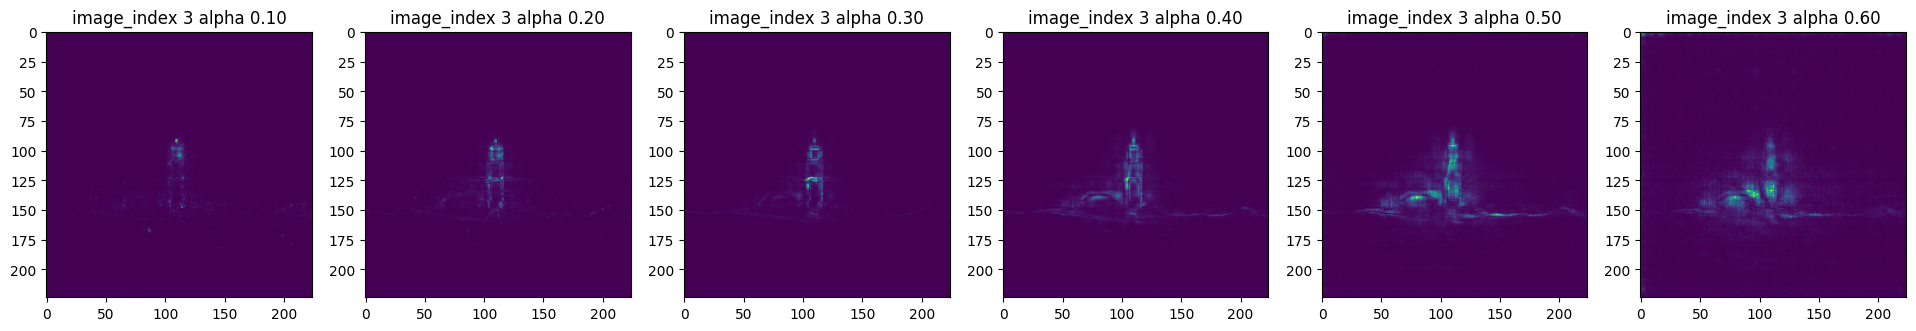

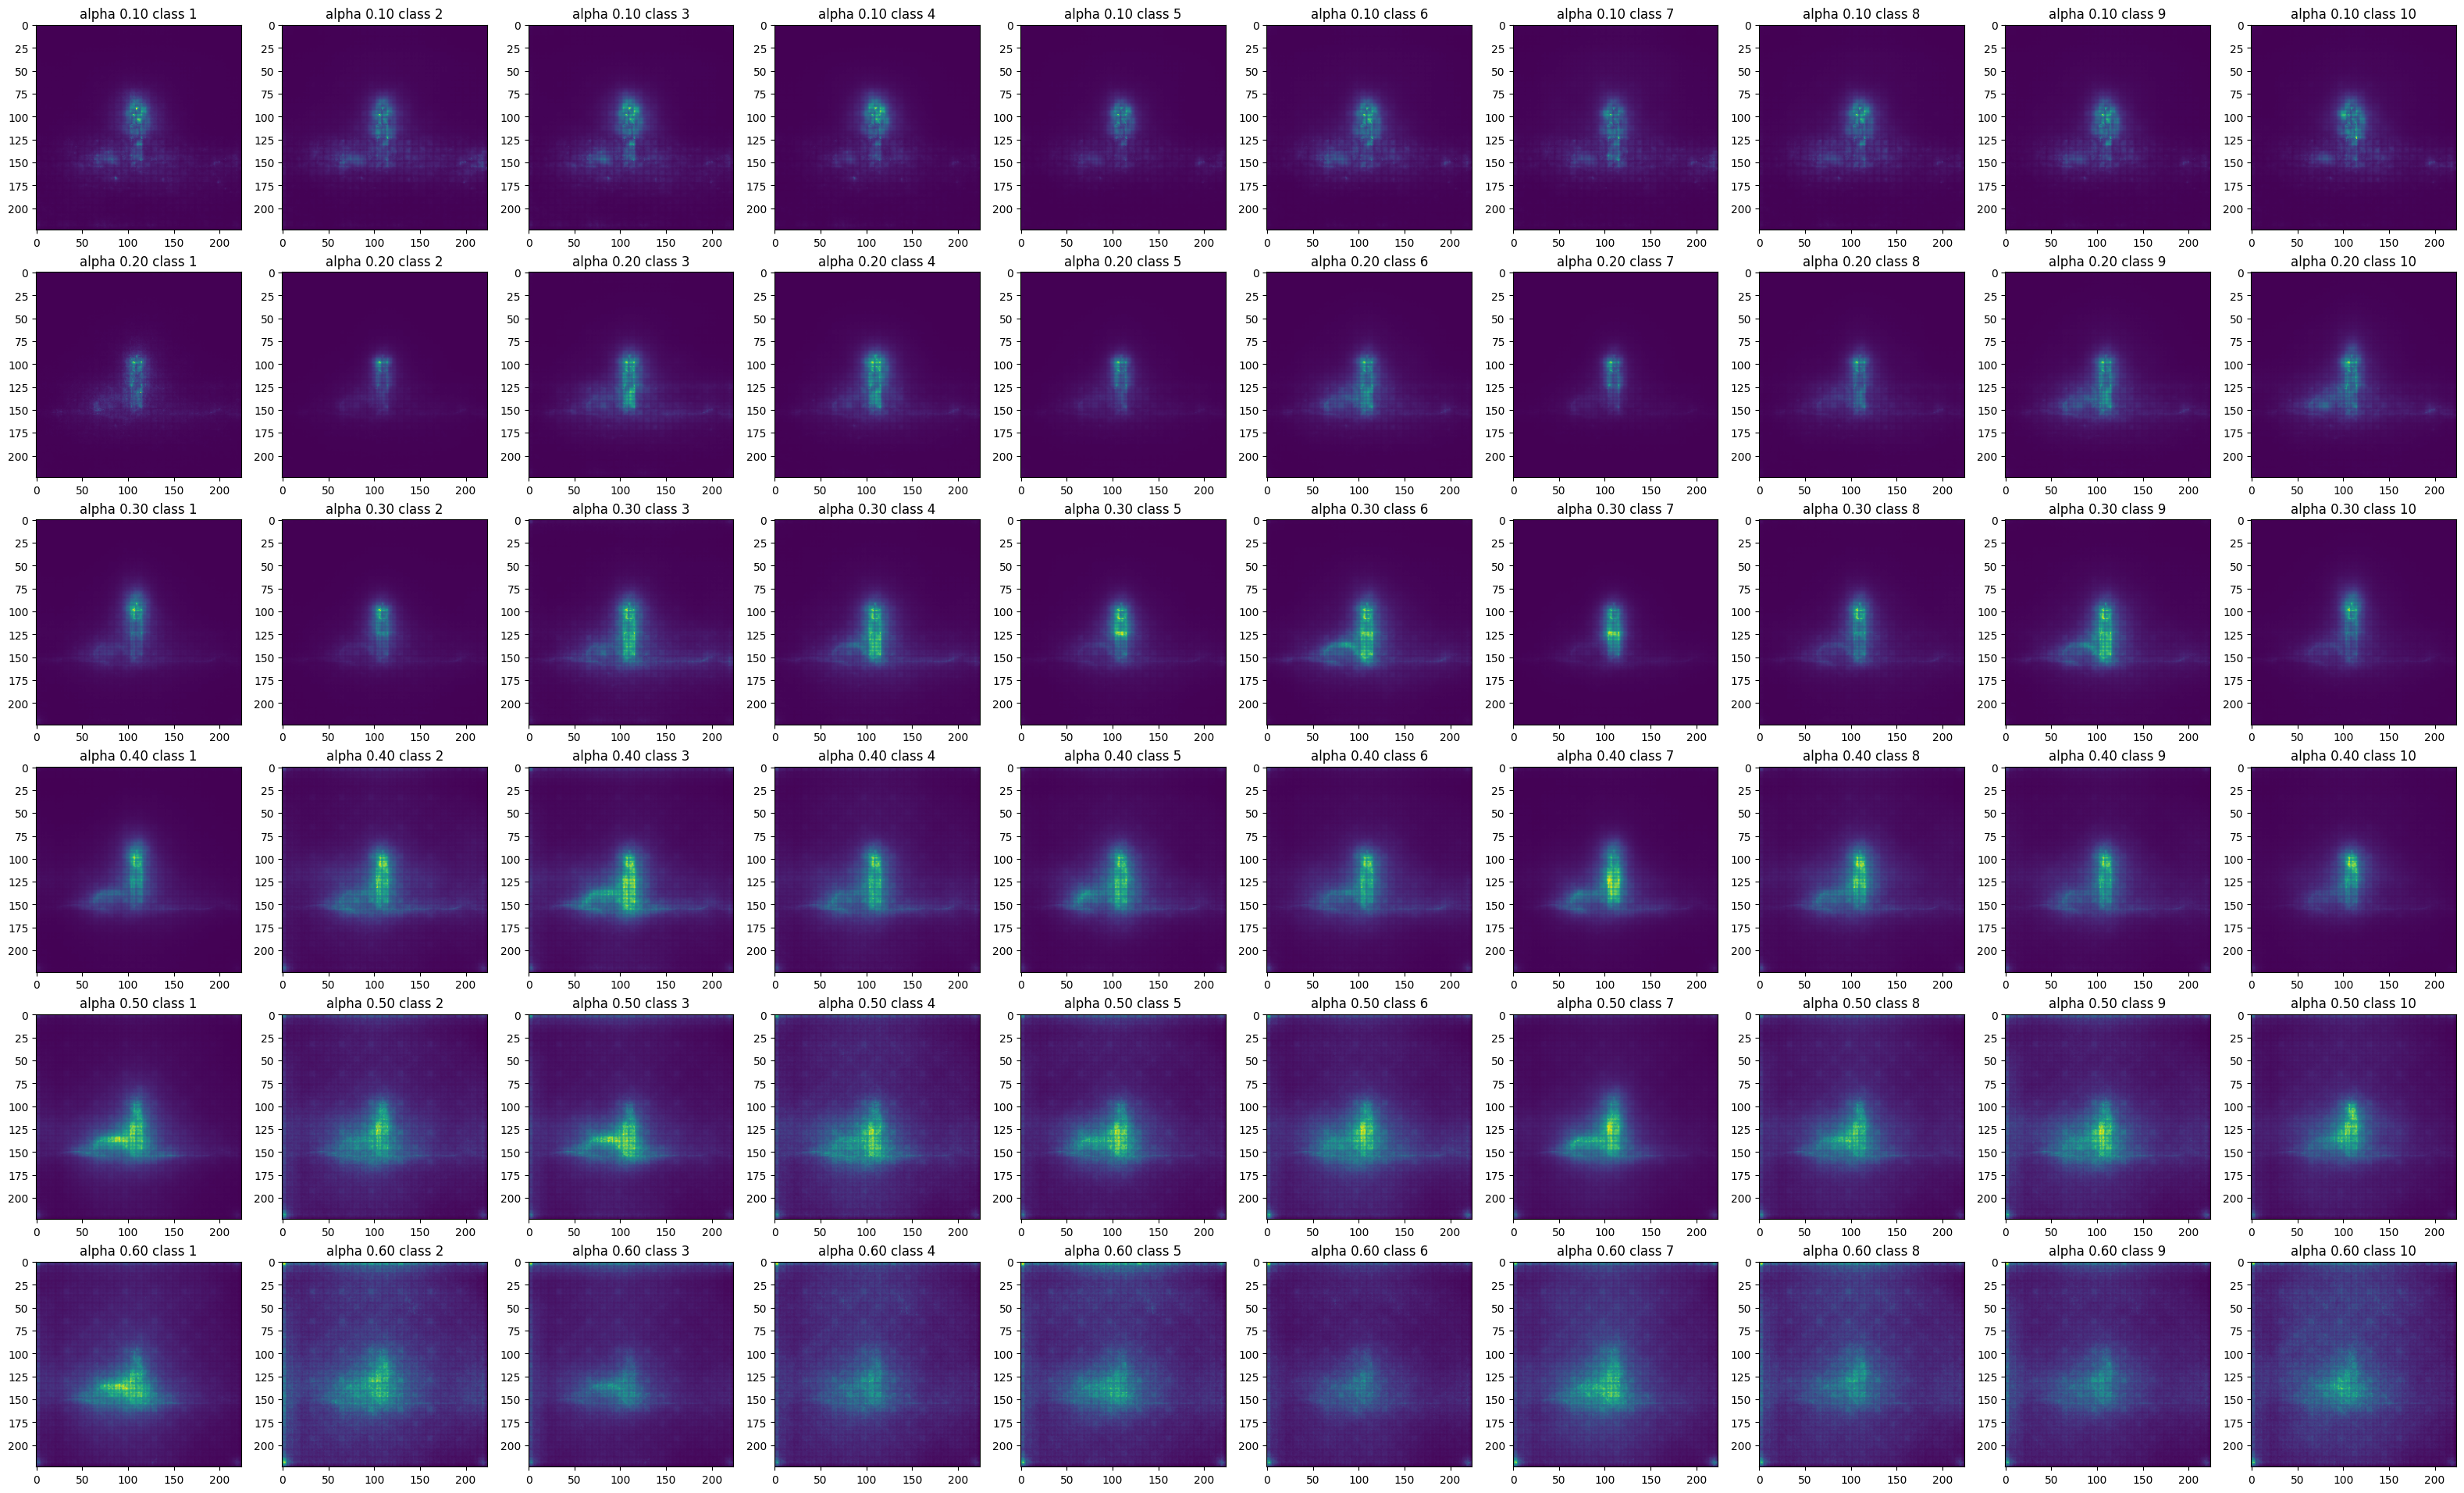

In [7]:
image_index = 9
titles = fisher_masks.index.to_series().apply(
    lambda x: f"{fisher_masks.index.names[0]} {x[0]} alpha {x[1]:.2f}"
)
plot_masks(
    fisher_masks.loc[image_index], titles=titles, imshow_args=imshow_args, ncols=6
)
meanx2 = temp_metadata.loc[("meanx2",image_index),"data_path"].apply(lambda x:np.load(x))
meanx = temp_metadata.loc[("meanx",image_index),"data_path"].apply(lambda x:np.load(x))
var = meanx2 - meanx**2
var = preprocess_masks(var, preprocesses=[sum_channels, minmax_normalize])
print(var.index.names)
titles = var.index.to_series().apply(
    lambda x: f"alpha {x[0]:.2f} class {x[1]}"
)
plot_masks(
    var, titles=titles, imshow_args=imshow_args, ncols=10
)

['image_index', 'alpha_mask_value']


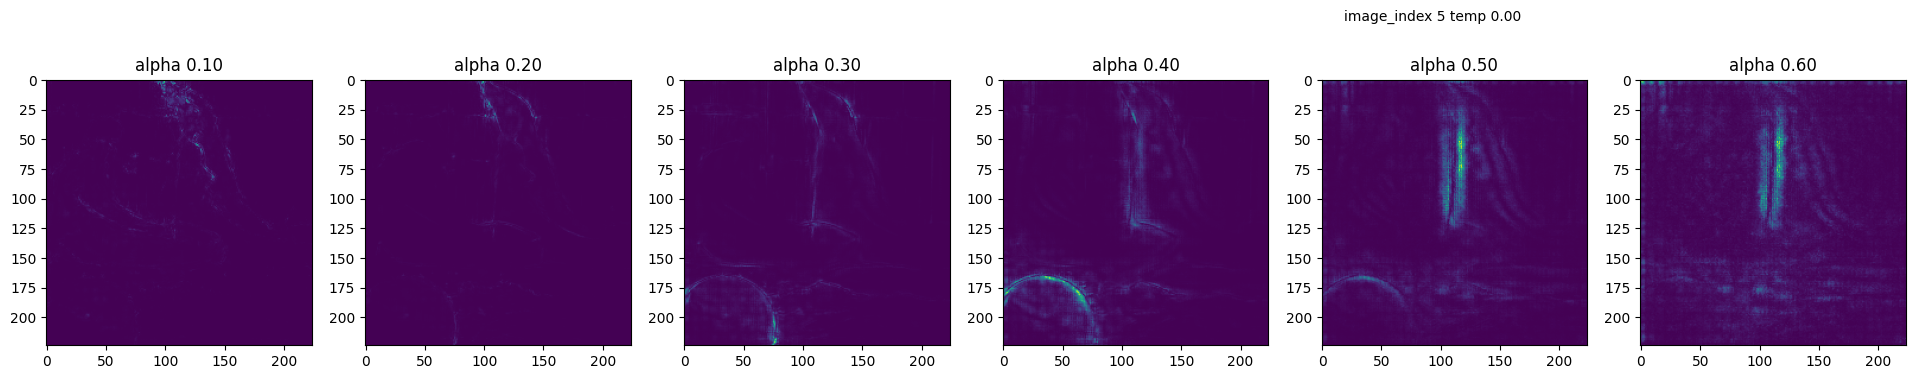

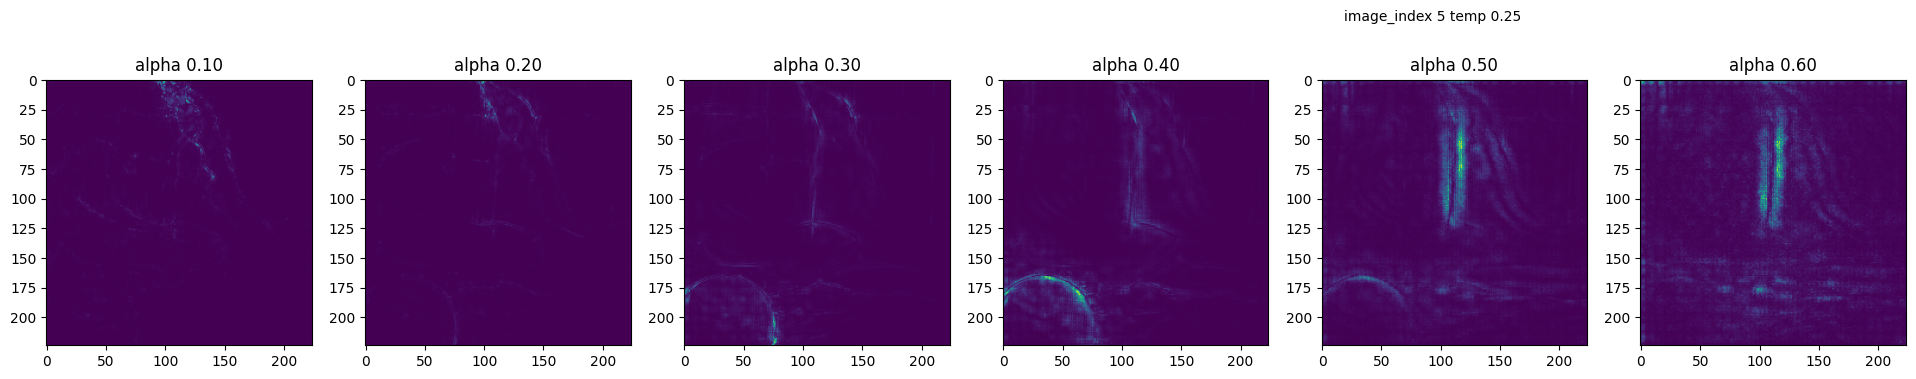

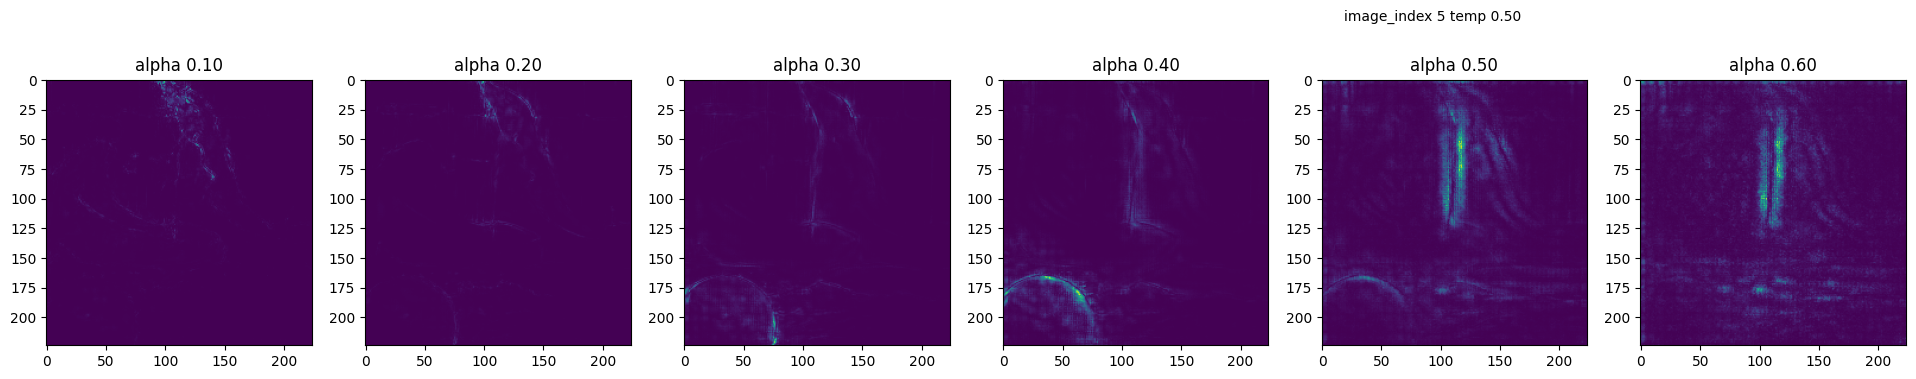

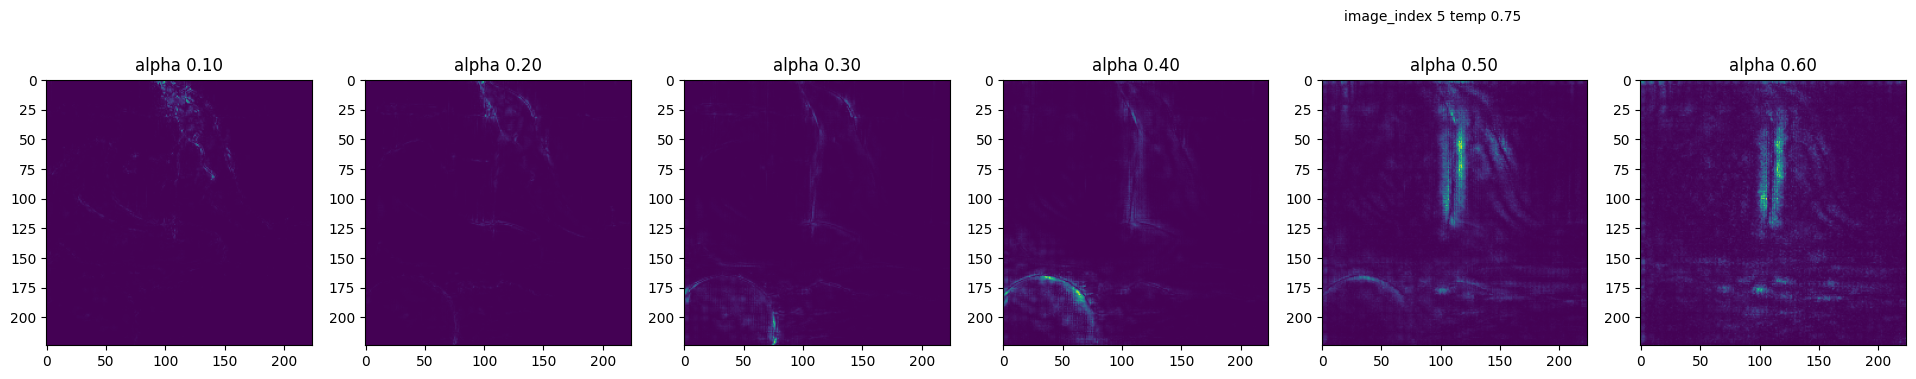

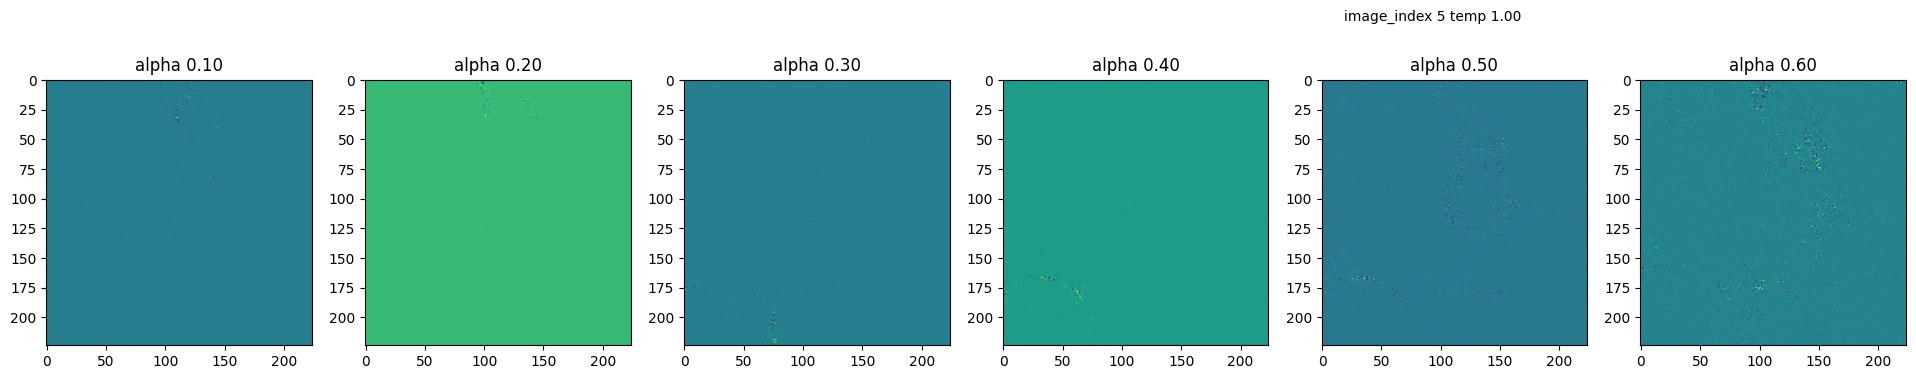

In [39]:
image_index = 5
temp = 0.1
projection_top_ks = temp_metadata.index.get_level_values("projection_top_k").unique()
print(fisher_masks.index.names)
for projection_id in projection_top_ks:
    prior = np.expand_dims(np.eye(shape[0])[projection_id - 1], axis=[1, 2, 3])
    smoothed_prior = (1 - temp) * prior + temp * uniform_prior
    fisher_masks = (
        temp_metadata.loc[(slice(None), image_index),]
        .groupby(["alpha_mask_value"])
        .apply(fisher_information, prior=prior)
    )
    fisher_masks = preprocess_masks(
        fisher_masks, preprocesses=[sum_channels, minmax_normalize]
    )

    titles = fisher_masks.index.to_series().apply(lambda x: f"alpha {x:.2f}")
    plot_masks(fisher_masks, titles=titles, imshow_args=imshow_args, ncols=6)
    plt.text(-250, -50, f"image_index {image_index} temp {temp:.2f}")